## Download Dataset From Kaggle

In [ ]:
def download_dataset():
  # set up kaggle api and credentials
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  # download the dataset
  !kaggle datasets download -d 'tanlikesmath/diabetic-retinopathy-resized'
  #unzip
  !mkdir diabetic-retinopathy-resized
  !unzip diabetic-retinopathy-resized.zip -d diabetic-retinopathy-resized
  !mv ./* diabetic-retinopathy-resized

## Import Packages

In [ ]:
import os
dataset_dir_exist = os.path.isdir('diabetic-retinopathy-resized')
if not dataset_dir_exist:
  print('downloading dataset')
  download_dataset()

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
import cv2
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
SEED = 77
IMG_SIZE = 512

## Load Datasets

In [ ]:
path = "./diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/"

In [ ]:
print('number of images in total - ',len(os.listdir(path)))

number of images in total -  35108


In [ ]:
labels = pd.read_csv("./diabetic-retinopathy-resized/trainLabels_cropped.csv")[['image', 'level']] 
print('number of images in total - ',len(labels))

number of images in total -  35108


In [ ]:
labels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
#format correctly
labels['image_name'] = [i+".jpeg" for i in labels['image'].values]

labels.head(10)

,image,level,image_name
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg
5,15_right,2,15_right.jpeg
6,16_left,4,16_left.jpeg
7,16_right,4,16_right.jpeg
8,17_left,0,17_left.jpeg
9,17_right,1,17_right.jpeg


In [ ]:
train_y, val_y = train_test_split(labels, test_size=0.3)
val_y, test_y = train_test_split(val_y, test_size=1.0/3.0)

train_y.shape, val_y.shape, test_y.shape


((24575, 3), (7022, 3), (3511, 3))

## Process Images
In this section, I performed a colored circle crop around image centres to remove uninformative dark areas. Meanwhile in ImageDataGenerator, the following transformations are applied to training set:

- shear_range
- zoom_range
- horizontal_flip
- rotation_range
- width_shift_range
- height_shift_range

In [ ]:
input_size = (300,300,3)

def load_ben_color(image, sigmaX=input_size[0]/10):
    
    image = image.astype(dtype=np.uint8)
    image = cv2.resize(image, input_size[:-1])
    image = cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return image

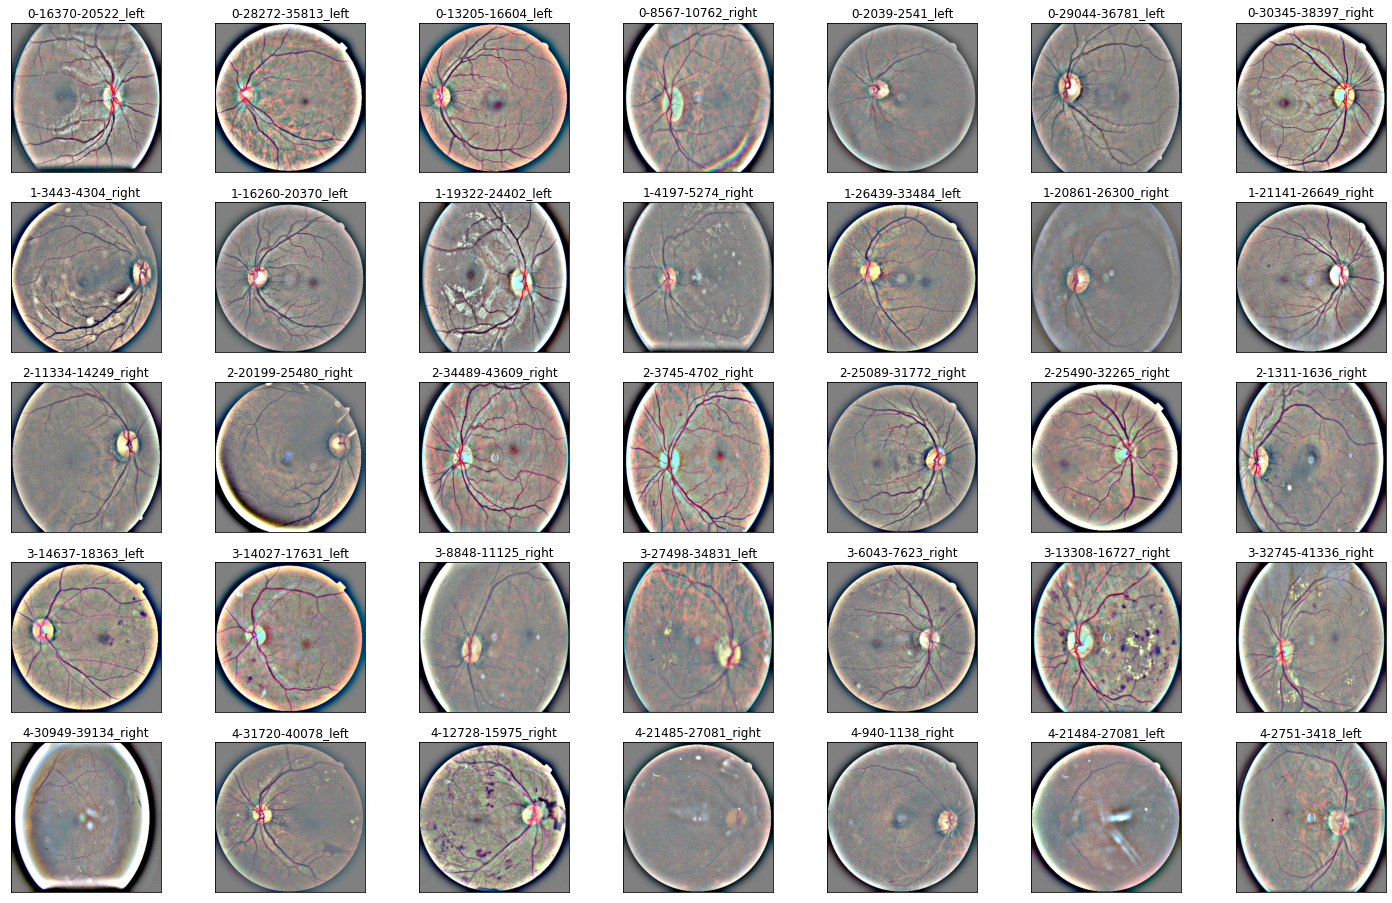

In [ ]:
# References: https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#3.A-Important-Update-on-Color-Version-of-Cropping-&-Ben's-Preprocessing

NUM_SAMP=7
dir = "data\\resized_train_cropped\\resized_train_cropped\\"
fig = plt.figure(figsize=(25, 16))

for class_id in sorted(labels['level'].unique()):
    for i, (idx, row) in enumerate(labels.loc[labels['level'] == class_id].sample(NUM_SAMP).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        
        p=path + row.image_name
        #print(path)
        image = cv2.imread(p)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        image = load_ben_color(image,sigmaX=10)
        
        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )
        

In [ ]:
batch_size = 32

data_gen_args_train = load_ben_color

data_gen_args_test = load_ben_color

datagen_train = ImageDataGenerator(
                                   shear_range=0.1,
                                   zoom_range= 0.1,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   preprocessing_function = data_gen_args_train)
datagen_val_test = ImageDataGenerator(preprocessing_function = data_gen_args_test)



In [ ]:
train_set = datagen_train.flow_from_dataframe(
    train_y,
    path,
    x_col="image_name",
    y_col="level",
    class_mode="raw",
    color_mode="rgb",
    batch_size=32,
    target_size=(300, 300))

val_set = datagen_val_test.flow_from_dataframe(
    val_y,
    path,
    x_col="image_name",
    y_col="level",
    class_mode="raw",
   color_mode="rgb",
    batch_size=32,
    target_size=(300, 300))

test_set = datagen_val_test.flow_from_dataframe(
    test_y,
    path,
    x_col="image_name",
    y_col="level",
    class_mode="raw",
   color_mode="rgb",
    batch_size=32,
    target_size=(300, 300))

Found 24575 validated image filenames.
Found 7022 validated image filenames.
Found 3511 validated image filenames.


## Build ConvNet Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (5, 5), input_shape=input_size, padding = "same", activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 32, kernel_size =  (5, 5), padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation = 'softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 300, 300, 128)     9728      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 100, 100, 128)    0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 100, 100, 128)     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 64)      204864    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 33, 33, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 33, 33, 64)       

## Train Model for 5 Epochs

In [ ]:
steps_per_epoch = train_set.n // batch_size
validation_steps = val_set.n // batch_size
epochs = 5
print(steps_per_epoch)
print(validation_steps)
model_train = model.fit(
    train_set,
    steps_per_epoch = 200,
    epochs = 5,
    validation_data = val_set,
    verbose=1,
    validation_steps = 100
)

767
219
Epoch 1/5
200/200 [==============================] - 4718s 24s/step - loss: 0.9682 - accuracy: 0.7111 - val_loss: 0.9950 - val_accuracy: 0.7384
Epoch 2/5
200/200 [==============================] - 4683s 23s/step - loss: 0.9072 - accuracy: 0.7286 - val_loss: 1.0457 - val_accuracy: 0.7406
Epoch 3/5
200/200 [==============================] - 4689s 23s/step - loss: 0.9152 - accuracy: 0.7225 - val_loss: 0.8909 - val_accuracy: 0.7394
Epoch 4/5
200/200 [==============================] - 4688s 23s/step - loss: 0.8749 - accuracy: 0.7356 - val_loss: 0.9000 - val_accuracy: 0.7394
Epoch 5/5
200/200 [==============================] - 4724s 24s/step - loss: 0.8899 - accuracy: 0.7268 - val_loss: 0.8548 - val_accuracy: 0.7387


## Plot ROC curves and Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from prettytable import PrettyTable
# Test model using test dataset
def test(model, y_test, test_gen):
    
    x_test = test_gen
    y_pred = model.predict(x_test, batch_size=100)
    print("Groud Truth values: ",y_test.shape)
    print(y_test)
    print('-'*40)
    print("Predicted values: ",y_pred.shape)
    print(y_pred)
    pred = np.argmax(y_pred, axis=1)
    test = np.argmax(y_test, axis=1)
    #pred = y_pred.round()
    #test = y_test.round()
    accuracy = (np.sum(np.argmax(y_pred, 1) == np.argmax(y_test,1))/y_test.shape[0])
    precision = metrics.precision_score(test, pred,average='weighted')
    recall = metrics.recall_score(test, pred,average='weighted')
    f1 = metrics.f1_score(test, pred,average='weighted')
    print(" ")
    Cnn_Table = PrettyTable(['Performance Metrics', '%'])
  
    # Add rows
    Cnn_Table.add_row(['Accuracy ',accuracy])
    Cnn_Table.add_row(['Precision',precision])
    Cnn_Table.add_row(['Recall/Sensitivity   ',recall])
    Cnn_Table.add_row(['F1_score ',f1])
    #myTable.add_row(['MLP_Confusion_Matrix',matrix])

    print(Cnn_Table)

    #Confusion Matrix
    print(" ")
    matrix = metrics.confusion_matrix(test, pred)
    print(" ")
    print('Confusion_Matrix:')
    print(" ")
    print(matrix)
    print(" ")
    
    print("classification_report: ")
    print('-'*40)
    print(metrics.classification_report(test, pred))
    
    
   
    
    # Plotting ROC curve
    y = y_test
    # Binarize the output
    y = label_binarize(y, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC for specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to specific class')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' ')
    
    # Plot ROC curve for multi class
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
print("Model is ready to Test")

Model is ready to Test


In [ ]:
from tensorflow.keras.utils import to_categorical

y_test = test_y['level'].map(lambda x: to_categorical(x, 5))
y_test = np.asarray(list(y_test))
y_test


array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

Groud Truth values:  (3511, 5)
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
----------------------------------------
Predicted values:  (3511, 5)
[[0.71884304 0.07311156 0.15843228 0.02933963 0.02027344]
 [0.7551162  0.06296384 0.14356443 0.02281022 0.01554534]
 [0.71924835 0.07296634 0.15827267 0.02927435 0.02023833]
 ...
 [0.72096586 0.07233922 0.15773004 0.0289922  0.01997266]
 [0.7216871  0.07179215 0.15790203 0.02883042 0.01978828]
 [0.72152877 0.07195738 0.15791844 0.02878848 0.01980698]]
 
+-----------------------+--------------------+
|  Performance Metrics  |         %          |
+-----------------------+--------------------+
|       Accuracy        | 0.7527769866135005 |
|       Precision       | 0.5666731915749021 |
| Recall/Sensitivity    | 0.7527769866135005 |
|       F1_score        | 0.6466004470651548 |
+-----------------------+--------------------+
 
 
Confusion_Matrix:
 
[[2643    0    0    0    0]
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: 

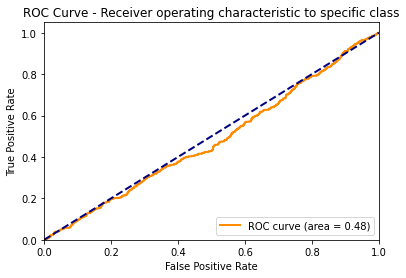

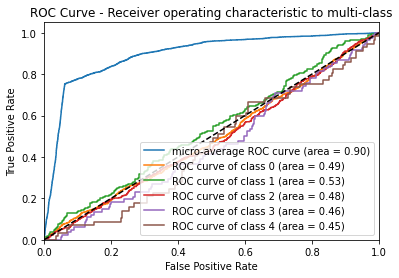

In [ ]:
test(model, y_test, test_set)
